## DDC Bessel

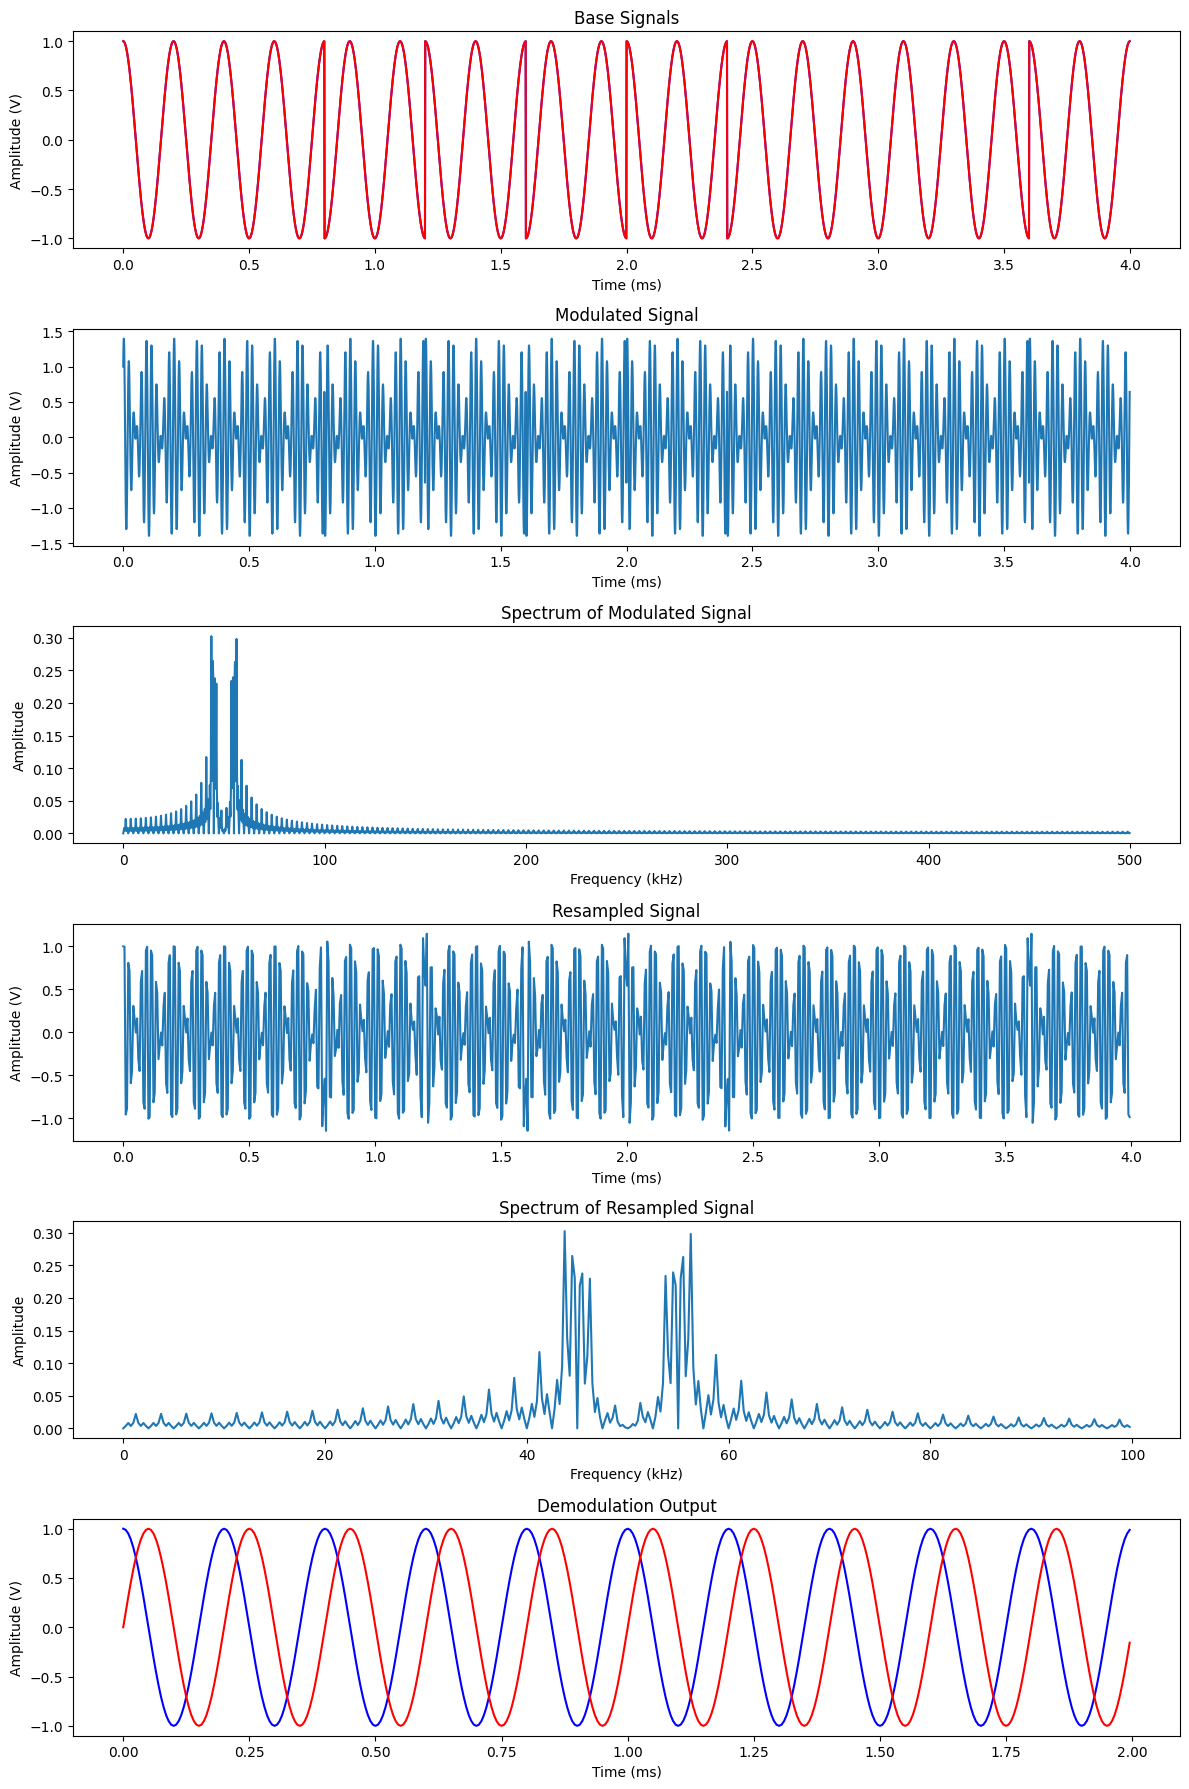

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square, sawtooth, resample, correlate

# Time base parameters -------------------------------------------------- #
fs = 1e6               # Sampling frequency: 1Mhz
dt = 1/fs              # Time scale
N = 4000               # Points
tv = np.arange(0, N) * dt  # Discrete time vector
fv = np.arange(0, N//2) * fs / N  # Discrete frequency vector

# Modulation ------------------------------------------------------------ #
fb = 5e3               # Base frequency: 5kHz
fc = 50e3              # Carrier frequency: 50kHz
sCCos = np.cos(2*np.pi*fc*tv)  # Q modulator
scSin = np.sin(2*np.pi*fc*tv)  # I modulator

# Single tone pulse ----------------------------------------------------- #
fp = 1e3
pulse = square(2*np.pi*fp*tv, duty=0.5) * 0.5 + 0.5
sBaseQ = pulse * np.cos(2*np.pi*fb*tv)
sBaseI = pulse * np.sin(2*np.pi*fb*tv)

# Linear FM pulse ------------------------------------------------------- #
A = 1                  # Amplitude: 1V
f0 = 1e3               # Start frequency: 1kHz
fshift = 10e3          # Frequency shift: 10kHz
fm = 0.4e3             # Modulation frequency: 40Hz

mod = (0.5*square(2*np.pi*fm*tv, duty=0.5) + 0.5) * (2*sawtooth(2*np.pi*fm*tv) + 1)
lfm = (0.5*square(2*np.pi*fm*tv, duty=0.5) + 0.5) * np.interp(tv, tv, mod, period=(1/fm))
sBaseQ = lfm
sBaseI = lfm

# BPSK pulse ------------------------------------------------------------ #
A = 1                  # Amplitude: 1V
fc = 5e3               # Carrier frequency: 5kHz
Rb = 1e3               # Baudrate: 1kbps
code = '1101010001'

cellv = np.arange(0, N/len(code)) * dt
cellp = np.cos(2*np.pi*fc*cellv)
celln = -np.cos(2*np.pi*fc*cellv)
bpsk = np.zeros(N)

for i, bit in enumerate(code):
    start = int(i * len(cellv))
    end = start + len(cellv)
    bpsk[start:end] = cellp if bit == '1' else celln

sBaseQ = bpsk
sBaseI = bpsk

# Modulation ------------------------------------------------------------ #
sMod = sBaseQ * sCCos + sBaseI * scSin
sModFftAbs = np.abs(np.fft.fft(sMod)[:N//2]) / (N/2)

# Plotting results ------------------------------------------------------ #
plt.figure(figsize=(12, 18))

plt.subplot(6, 1, 1)
plt.plot(tv*1000, sBaseQ, 'b', tv*1000, sBaseI, 'r')
plt.title('Base Signals')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(6, 1, 2)
plt.plot(tv*1000, sMod)
plt.title('Modulated Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(6, 1, 3)
plt.plot(fv/1000, sModFftAbs)
plt.title('Spectrum of Modulated Signal')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')

# Resampling for demodulation -------------------------------------------- #
rfs = 200e3            # Resampling frequency: 200kHz
rN = int(N * rfs / fs)
rtv = np.arange(rN) * (1 / rfs)  # Resampled time vector
rfv = np.arange(0, rN//2) * rfs / rN  # Resampled frequency vector

rSMod = resample(sMod, rN)
rSModFftAbs = np.abs(np.fft.fft(rSMod)[:rN//2]) / (rN/2)

plt.subplot(6, 1, 4)
plt.plot(rtv*1000, rSMod)
plt.title('Resampled Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(6, 1, 5)
plt.plot(rfv/1000, rSModFftAbs)
plt.title('Spectrum of Resampled Signal')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')

# Simulating some kind of demodulation ----------------------------------- #
# Assuming simple differential decoding or something equivalent
# This is just illustrative. Actual demodulation will depend on the method used.
deBaseQ = np.cos(2 * np.pi * fc * rtv)
deBaseI = np.sin(2 * np.pi * fc * rtv)

plt.subplot(6, 1, 6)
plt.plot(rtv[0:rN//2]*1000, deBaseQ[0:rN//2], 'b', rtv[0:rN//2]*1000, deBaseI[0:rN//2], 'r')
plt.title('Demodulation Output')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.tight_layout()
plt.show()

## DDC LPF

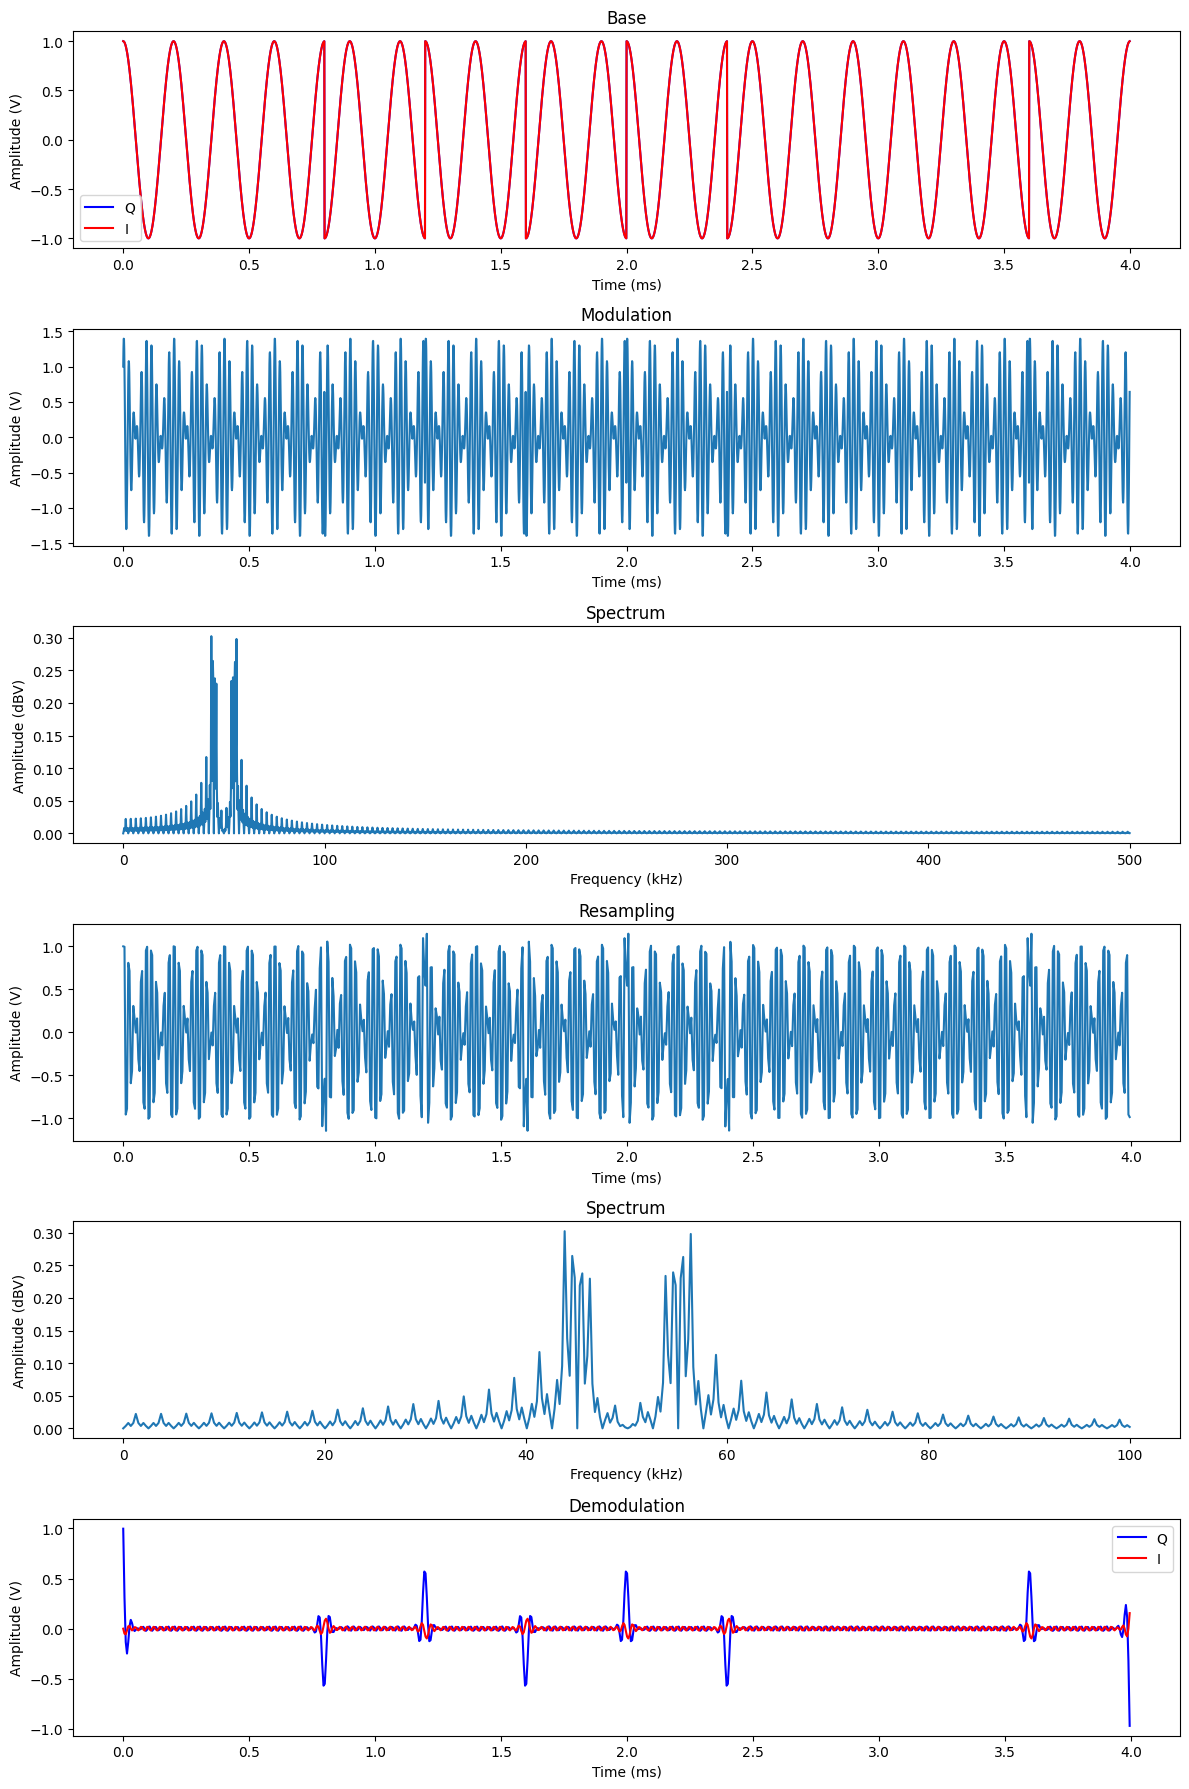

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square, sawtooth, resample, butter, filtfilt
from scipy.fft import fft

# Time base parameters -------------------------------------------------- #
fs = 1e6                # Sampling frequency: 1Mhz
dt = 1/fs               # Time scale
N = 4000                # Points
tv = np.linspace(0, (N-1)*dt, N)  # Discrete time vector
fv = np.linspace(0, fs/2, N//2)   # Discrete frequency vector

# Modulation ------------------------------------------------------------ #
fb = 5e3                # Base frequency: 5kHz
fc = 50e3               # Carrier frequency: 50kHz

sCCos = np.cos(2 * np.pi * fc * tv)
scSin = np.sin(2 * np.pi * fc * tv)

# Single tone pulse ----------------------------------------------------- #
fp = 1e3
pulse = 0.5 * (square(2 * np.pi * fp * tv, duty=50) + 1)
sBaseQ = pulse * np.cos(2 * np.pi * fb * tv)
sBaseI = pulse * np.sin(2 * np.pi * fb * tv)

# Linear FM pulse ------------------------------------------------------- #
A = 1                   # Amplitude: 1V
f0 = 1e3                # Start frequency: 1kHz
fshift = 10e3           # Frequency shift: 10kHz
fm = 0.4e3              # Modulation frequency: 40Hz

mod = (0.5 * square(2 * np.pi * fm * tv, duty=50) + 0.5) * (2 * sawtooth(2 * np.pi * fm * tv) + 1)
# Generating VCO (voltage-controlled oscillator)
t_span = np.linspace(0, 1/fm, int(fs/fm), endpoint=False)
vco_wave = np.interp(tv, t_span, np.linspace(f0, f0 + fshift, len(t_span)))
lfm = (0.5 * square(2 * np.pi * fm * tv, duty=50) + 0.5) * np.cos(2 * np.pi * vco_wave * tv)
sBaseQ = lfm
sBaseI = lfm

# BPSK pulse ------------------------------------------------------------ #
A = 1                   # Amplitude: 1V
fc = 5e3                # Carrier frequency: 5kHz
Rb = 1e3                # Baudrate: 1kbps
code = '1101010001'

bpsk = np.zeros(N)
for i, bit in enumerate(code):
    start_idx = int(i * N / len(code))
    end_idx = int((i + 1) * N / len(code))
    bpsk[start_idx:end_idx] = np.cos(2 * np.pi * fc * tv[start_idx:end_idx]) if bit == '1' else -np.cos(2 * np.pi * fc * tv[start_idx:end_idx])

sBaseQ = bpsk
sBaseI = bpsk

# Modulation ------------------------------------------------------------ #
sMod = sBaseQ * sCCos + sBaseI * scSin
sModFftAbs = np.abs(fft(sMod)[:N//2]) / (N/2)

# Plotting the results -------------------------------------------------- #
plt.figure(figsize=(12, 18))
plt.subplot(6, 1, 1)
plt.plot(tv * 1000, sBaseQ, 'b', label='Q')
plt.plot(tv * 1000, sBaseI, 'r', label='I')
plt.title('Base')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(tv * 1000, sMod)
plt.title('Modulation')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(6, 1, 3)
plt.plot(fv / 1000, sModFftAbs)
plt.title('Spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

# Resampling ------------------------------------------------------------ #
rfs = 200e3             # Resampling frequency: 200kHz
rN = int(N * rfs / fs)
rtv = np.linspace(0, (rN-1) * (1/rfs), rN)  # Resampled time vector
rfv = np.linspace(0, rfs/2, rN//2)          # Resampled frequency vector

rSMod = resample(sMod, rN)
rSModFftAbs = np.abs(fft(rSMod)[:rN//2]) / (rN/2)

plt.subplot(6, 1, 4)
plt.plot(rtv * 1000, rSMod)
plt.title('Resampling')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(6, 1, 5)
plt.plot(rfv / 1000, rSModFftAbs)
plt.title('Spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')

# Demodulation ---------------------------------------------------------- #
# LPF filter design for demodulation
b, a = butter(4, (2 * 30e3) / rfs, 'low')
deBaseQ = filtfilt(b, a, rSMod * np.cos(2 * np.pi * fc * rtv))
deBaseI = filtfilt(b, a, rSMod * np.sin(2 * np.pi * fc * rtv))

plt.subplot(6, 1, 6)
plt.plot(rtv * 1000, deBaseQ, 'b', label='Q')
plt.plot(rtv * 1000, deBaseI, 'r', label='I')
plt.title('Demodulation')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')
plt.legend()

plt.tight_layout()
plt.show()

## FFT Res

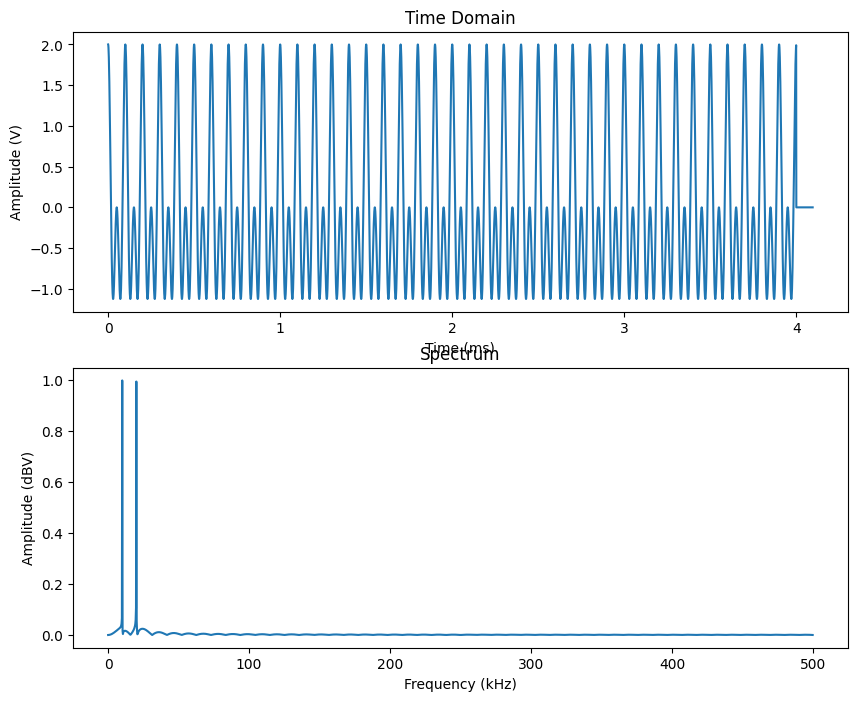

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft

# Time base parameters
fs = 1e6               # Sampling frequency: 1Mhz
dt = 1/fs              # Time scale
N = 4000               # Points
fftN = 4096            # FFT points
t = np.arange(0, N) * dt      # Discrete time vector
tv = np.arange(0, fftN) * dt  # Discrete time vector
fv = np.arange(0, fftN//2) * fs / fftN  # Discrete frequency vector

# Signal
f1 = 10e3
f2 = 20e3

sgn1 = np.cos(2 * np.pi * f1 * t)
sgn2 = np.cos(2 * np.pi * f2 * t)
sgn = sgn1 + sgn2
sgn = np.concatenate((sgn, np.zeros(fftN - N)))  # Zero padding

# FFT calculation
sgnFftAbs = np.abs(fft(sgn)) / (N/2)

# Plotting
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(tv * 1000, sgn)
plt.title('Time Domain')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (V)')

plt.subplot(2, 1, 2)
plt.plot(fv / 1000, sgnFftAbs[:fftN//2])
plt.title('Spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (dBV)')
plt.show()